# Ampparit Popular Stories Analysis

This notebook analyzes voting patterns and engagement metrics for stories from Ampparit.com, a Finnish news aggregator.

## Overview

The analysis examines the relationship between story popularity (clicks) and user voting behavior (plus votes and minus votes) to understand engagement patterns across different news sources.

## Data Source

- **API**: Ampparit.com featured items API
- **Time Range**: Last 24 hours
- **Sample Size**: Up to 5,000 most recent stories
- **Key Metrics**: clicks, plus_votes, minus_votes, source, category, timestamp

## Analysis Components

### 1. Source Analysis
- **News source rankings** by total reach and per-story engagement
- Comparison of voting patterns across different publishers
- Identification of high-impact sources for anti-clickbait initiatives

### 2. Correlation Analysis
- **Pearson and Spearman correlations** between clicks and votes
- Examines both positive and negative voting patterns
- Statistical significance testing (p-values)

### 3. Visualization
- Scatter plots with trend lines showing clicks vs votes
- Distribution charts showing average votes across click ranges
- Automatic click range calculation using percentiles (deciles)

### 4. Plus/Minus Vote Ratio
- Calculates plus_votes / minus_votes ratio for stories with negative feedback
- Identifies most positively and negatively received content
- Correlation analysis between popularity and vote ratio
- Distribution analysis of sentiment across the dataset

## Key Findings

### Overall Patterns
- **Weak positive correlation** between clicks and both vote types (r ≈ 0.2-0.3)
- Popular articles receive more votes overall, but ratio varies by topic
- Political/controversial topics tend to have higher plus/minus ratios
- Sports disappointments and trivial content often receive disproportionate negative votes
- Median plus/minus ratio typically < 1.0, indicating general audience negativity bias

### Source Insights
- **Top tabloids** (Ilta-Sanomat, Iltalehti) dominate with ~22% of total traffic
- **Verkkouutiset** shows highest engagement per story (11.5 avg plus votes)
- **Uusi Suomi** achieves highest per-story clicks (1,279 avg) despite low volume
- **Yle** (public broadcaster) maintains strong positive reception (4.7:3.1 plus/minus ratio)
- Tech/gaming sources show low voting activity despite decent readership


## External Dependencies

- `numpy`, `scipy` - Statistical analysis
- `matplotlib` - Visualization
- `pytz` - Timezone handling

In [1]:
AMPPARIT_URL = r"https://www.ampparit.com/api/itemlists/anon/featured?limit=72&maxTimestamp={max_timestamp}"

In [2]:
# Autoreload
%load_ext autoreload
%autoreload 2

from datetime import datetime, timedelta
import logging
from meri.scraper import try_setup_requests_cache

logging.basicConfig(level=logging.INFO)

logger = logging.getLogger(__name__)

try_setup_requests_cache()

from meri.http.requests import SpoofedRequestsBackend

session = SpoofedRequestsBackend()

fromtime = datetime.now() - timedelta(days=1)  # Fetch stories from the last day
# Round to nearest hour
fromtime = fromtime.replace(minute=0, second=0, microsecond=0)


2025-12-14 13:54:22 [debug    ] Registered discoverer          class_name=IltalehtiFeedDiscoverer name=iltalehti weight=50


/app/.venv/lib/python3.12/site-packages/pydantic_settings/sources.py:659: UserWarning: directory "/run/secrets" does not exist
  warnings.warn(f'directory "{path}" does not exist')


2025-12-14 13:54:22 [debug    ] Registered discoverer          class_name=RSSDiscoverer name=rss weight=50
2025-12-14 13:54:22 [debug    ] Registered discoverer          class_name=SitemapDiscoverer name=sitemap weight=50
2025-12-14 13:54:22 [debug    ] Cache set up at /home/vscode/.cache/meri/requests-cache


In [3]:
from datetime import datetime, timedelta
import random
import time
import pytz

def fetch_ampparit_data(limit: int = 500, fromtime: timedelta | datetime | None = None):
    """Fetch Ampparit data with given limit.
    
    Structure of the data is documented at:
        {
            "data": [
                {
                    "id": "0ace4083-767c-58c4-b824-ccbeeac513a6",
                    "timestamp": 1765709162,
                    "title": "Niko Anttola, 22, latasi jälleen huippunäytön - yksi seikka korosti uran parasta hiihtoa",
                    "link": "https://yle.fi/a/74-20199667?origin=rss",
                    "source": "Yle",
                    "sourceId": 1,
                    "tags": [],
                    "clicks": 471,
                    "plus_votes": 1,
                    "minus_votes": 0,
                    "level": 1,
                    "category": "Talvilajit",
                    "categoryId": 97,
                    "isCustomItem": false,
                    "isPaywalled": false,
                    "batch": {
                        "id": 9169103,
                        "size": 1
                    }
                }
            ],

            "timestamp": 1765715236596,
            "copyright": "Ampparit data ja API käyttö yksinoikeudella ampparit.com, Alma Media Oyj"
        }
    """
    eest_tz = pytz.timezone("Europe/Helsinki")
    eest_now = datetime.now(tz=eest_tz)

    timestamp: int

    match fromtime:
        case timedelta():
            timestamp = int((eest_now - fromtime).timestamp())
        case datetime():
            timestamp = int(fromtime.timestamp())
        case None:
            timestamp = int(eest_now.timestamp()) - 1
        case _:
            raise ValueError("Invalid timestamp type")

    # Set initial value
    was_cached = True

    for i in range(0, limit, 72):
        print(f"Fetching items {i} to {i+72} with max_timestamp={timestamp}")
        url = AMPPARIT_URL.format(max_timestamp=timestamp)

        if not was_cached:
            time.sleep(random.uniform(0.1, 1.5))  # Be polite

        was_cached = False
        # Check if url is in requests-cache
        if session.cache.contains(url=url):
            was_cached = True

        response = session.get(url)

        response.raise_for_status()

        jsdata = response.json()
        new_timestamp = timestamp
        for item in jsdata.get("data", []):
            yield item
            new_timestamp = min(new_timestamp, item["timestamp"])

        # Remove ms if present
        if new_timestamp > 1_000_000_000_000:
            logger.debug("Converting milliseconds to seconds for timestamp.")
            new_timestamp = new_timestamp // 1000

        assert new_timestamp < timestamp, "Timestamps are not decreasing!"
        timestamp = new_timestamp


# Fetch stories from last 1 day
stories = list(fetch_ampparit_data(limit=10000, fromtime=fromtime))

# Sort stories by views (clicks)
stories_sorted = sorted(stories, key=lambda x: x["clicks"], reverse=True)
for item in stories_sorted[:10]:  # Top 10 stories by clicks
    print(f"{item['clicks']:5} views - {item['title']} ({item['link']})")

# Print range of timestamps fetched
timestamps = [item["timestamp"] for item in stories]
if timestamps:
    min_timestamp = min(timestamps)
    max_timestamp = max(timestamps)
    min_dt = datetime.fromtimestamp(min_timestamp)
    max_dt = datetime.fromtimestamp(max_timestamp)
    print(f"Fetched stories from {min_dt} to {max_dt}")

Fetching items 0 to 72 with max_timestamp=1765630800
Fetching items 72 to 144 with max_timestamp=1765624813
Fetching items 144 to 216 with max_timestamp=1765619800
Fetching items 216 to 288 with max_timestamp=1765614352
Fetching items 288 to 360 with max_timestamp=1765608850
Fetching items 360 to 432 with max_timestamp=1765602159
Fetching items 432 to 504 with max_timestamp=1765578817
Fetching items 504 to 576 with max_timestamp=1765569332
Fetching items 576 to 648 with max_timestamp=1765563695
Fetching items 648 to 720 with max_timestamp=1765559511
Fetching items 720 to 792 with max_timestamp=1765555535
Fetching items 792 to 864 with max_timestamp=1765551840
Fetching items 864 to 936 with max_timestamp=1765548287
Fetching items 936 to 1008 with max_timestamp=1765545347
Fetching items 1008 to 1080 with max_timestamp=1765541801
Fetching items 1080 to 1152 with max_timestamp=1765538848
Fetching items 1152 to 1224 with max_timestamp=1765535667
Fetching items 1224 to 1296 with max_timestam

In [4]:
# Group stories by source and analyze popularity
from collections import defaultdict

NUM_TOP_SOURCES = 25

source_stats = defaultdict(lambda: {
    "count": 0,
    "total_clicks": 0,
    "total_plus_votes": 0,
    "total_minus_votes": 0,
    "stories": []
})

for story in stories:
    source = story.get("source", "Unknown")
    source_stats[source]["count"] += 1
    source_stats[source]["total_clicks"] += story["clicks"]
    source_stats[source]["total_plus_votes"] += story["plus_votes"]
    source_stats[source]["total_minus_votes"] += story["minus_votes"]
    source_stats[source]["stories"].append(story)

# Calculate averages and create ranked list
source_rankings = []
for source, stats in source_stats.items():
    avg_clicks = stats["total_clicks"] / stats["count"]
    avg_plus = stats["total_plus_votes"] / stats["count"]
    avg_minus = stats["total_minus_votes"] / stats["count"]
    
    source_rankings.append({
        "source": source,
        "count": stats["count"],
        "total_clicks": stats["total_clicks"],
        "avg_clicks": avg_clicks,
        "avg_plus_votes": avg_plus,
        "avg_minus_votes": avg_minus,
        "stories": stats["stories"]
    })

# Sort by total clicks (popularity)
source_rankings_by_total = sorted(source_rankings, key=lambda x: x["total_clicks"], reverse=True)

# Sort by average clicks per story
source_rankings_by_avg = sorted(source_rankings, key=lambda x: x["avg_clicks"], reverse=True)

print(f"News Source Analysis")
print(f"=" * 80)
print(f"Total sources: {len(source_rankings)}")
print(f"Total stories: {sum(s['count'] for s in source_rankings)}")

print(f"\n{'TOP {} SOURCES BY TOTAL CLICKS (Overall Reach)'.format(NUM_TOP_SOURCES):^80}")
print(f"-" * 80)
print(f"{'Rank':<5} {'Source':<25} {'Stories':<10} {'Total Clicks':<15} {'Avg Clicks':<12}")
print(f"-" * 80)

for i, source_data in enumerate(source_rankings_by_total[:NUM_TOP_SOURCES], 1):
    print(f"{i:<5} {source_data['source']:<25} {source_data['count']:<10} "
          f"{source_data['total_clicks']:<15} {source_data['avg_clicks']:<12.1f}")

print(f"\n{'TOP {} SOURCES BY AVERAGE CLICKS (Per-Story Engagement)'.format(NUM_TOP_SOURCES):^80}")
print(f"-" * 80)
print(f"{'Rank':<5} {'Source':<25} {'Stories':<10} {'Avg Clicks':<12} {'Total Clicks':<15}")
print(f"-" * 80)

for i, source_data in enumerate(source_rankings_by_avg[:NUM_TOP_SOURCES], 1):
    # Only show sources with at least 5 stories to avoid outliers
    if source_data['count'] >= 5:
        print(f"{i:<5} {source_data['source']:<25} {source_data['count']:<10} "
              f"{source_data['avg_clicks']:<12.1f} {source_data['total_clicks']:<15}")

print(f"\n{'SOURCE ENGAGEMENT METRICS':^80}")
print(f"-" * 80)
print(f"{'Source':<25} {'Stories':<10} {'Avg +votes':<12} {'Avg -votes':<12}")
print(f"-" * 80)

for source_data in source_rankings_by_total[:NUM_TOP_SOURCES]:
    print(f"{source_data['source']:<25} {source_data['count']:<10} "
          f"{source_data['avg_plus_votes']:<12.2f} {source_data['avg_minus_votes']:<12.2f}")

News Source Analysis
Total sources: 56
Total stories: 10008

                 TOP 25 SOURCES BY TOTAL CLICKS (Overall Reach)                 
--------------------------------------------------------------------------------
Rank  Source                    Stories    Total Clicks    Avg Clicks  
--------------------------------------------------------------------------------
1     Iltalehti                 1235       1215792         984.4       
2     Ilta-Sanomat              1211       1175520         970.7       
3     MTVuutiset.fi             884        449254          508.2       
4     Yle                       955        350939          367.5       
5     Verkkouutiset             390        344448          883.2       
6     HS.fi                     554        213581          385.5       
7     Seiska                    200        162519          812.6       
8     Kauppalehti               309        138173          447.2       
9     Tekniikka&Talous          168        12820

In [5]:
import numpy as np
from scipy.stats import pearsonr, spearmanr

# Extract clicks, minus votes, and plus votes for correlation analysis
clicks = [item["clicks"] for item in stories]
minus_votes = [item["minus_votes"] for item in stories]
plus_votes = [item["plus_votes"] for item in stories]

# Calculate correlations for minus votes
minus_pearson_corr, minus_pearson_p = pearsonr(clicks, minus_votes)
minus_spearman_corr, minus_spearman_p = spearmanr(clicks, minus_votes)

# Calculate correlations for plus votes
plus_pearson_corr, plus_pearson_p = pearsonr(clicks, plus_votes)
plus_spearman_corr, plus_spearman_p = spearmanr(clicks, plus_votes)

print(f"Correlation Analysis: Clicks vs Votes")
print(f"=" * 60)
print(f"Number of stories: {len(stories)}")
print(f"\n{'MINUS VOTES':^60}")
print(f"-" * 60)
print(f"Pearson correlation:  {minus_pearson_corr:.4f} (p-value: {minus_pearson_p:.4e})")
print(f"Spearman correlation: {minus_spearman_corr:.4f} (p-value: {minus_spearman_p:.4e})")

if abs(minus_pearson_corr) < 0.3:
    minus_strength = "weak"
elif abs(minus_pearson_corr) < 0.7:
    minus_strength = "moderate"
else:
    minus_strength = "strong"

minus_direction = "positive" if minus_pearson_corr > 0 else "negative"
print(f"\nThere is a {minus_strength} {minus_direction} correlation between clicks and minus votes.")

print(f"\n{'PLUS VOTES':^60}")
print(f"-" * 60)
print(f"Pearson correlation:  {plus_pearson_corr:.4f} (p-value: {plus_pearson_p:.4e})")
print(f"Spearman correlation: {plus_spearman_corr:.4f} (p-value: {plus_spearman_p:.4e})")

if abs(plus_pearson_corr) < 0.3:
    plus_strength = "weak"
elif abs(plus_pearson_corr) < 0.7:
    plus_strength = "moderate"
else:
    plus_strength = "strong"

plus_direction = "positive" if plus_pearson_corr > 0 else "negative"
print(f"\nThere is a {plus_strength} {plus_direction} correlation between clicks and plus votes.")

print(f"\n{'SUMMARY':^60}")
print(f"-" * 60)
print(f"More clicks → {'more' if minus_pearson_corr > 0 else 'fewer'} minus votes (r={minus_pearson_corr:.3f})")
print(f"More clicks → {'more' if plus_pearson_corr > 0 else 'fewer'} plus votes (r={plus_pearson_corr:.3f})")

Correlation Analysis: Clicks vs Votes
Number of stories: 10008

                        MINUS VOTES                         
------------------------------------------------------------
Pearson correlation:  0.2428 (p-value: 2.8415e-134)
Spearman correlation: 0.2431 (p-value: 1.4865e-134)

There is a weak positive correlation between clicks and minus votes.

                         PLUS VOTES                         
------------------------------------------------------------
Pearson correlation:  0.2117 (p-value: 7.9974e-102)
Spearman correlation: 0.2007 (p-value: 1.7069e-91)

There is a weak positive correlation between clicks and plus votes.

                          SUMMARY                           
------------------------------------------------------------
More clicks → more minus votes (r=0.243)
More clicks → more plus votes (r=0.212)


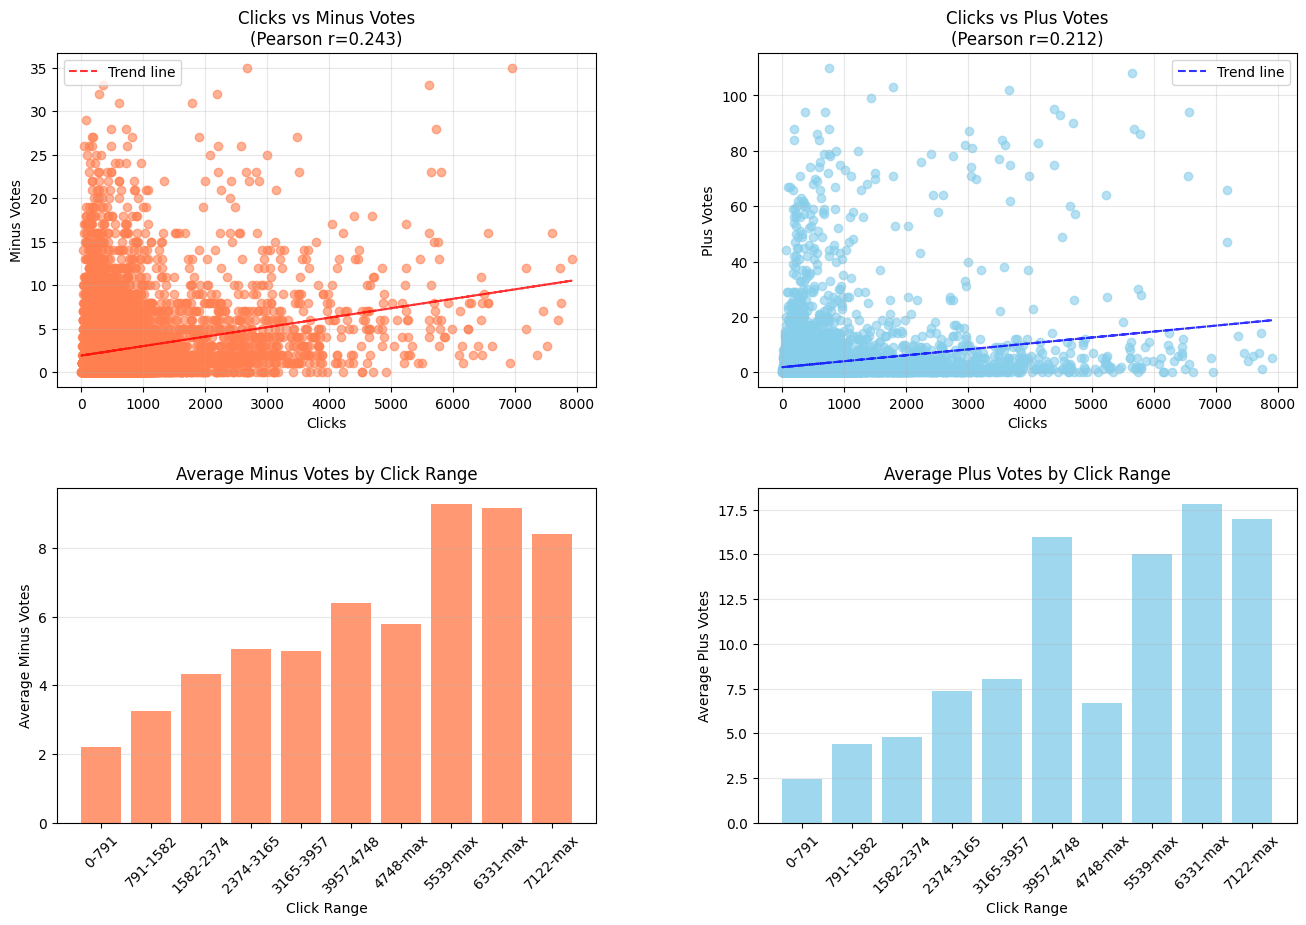

In [9]:
# Visualize the relationship
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# Scatter plot - Minus Votes
ax1 = fig.add_subplot(gs[0, 0])
ax1.scatter(clicks, minus_votes, alpha=0.6, color='coral')
ax1.set_xlabel('Clicks')
ax1.set_ylabel('Minus Votes')
ax1.set_title(f'Clicks vs Minus Votes\n(Pearson r={minus_pearson_corr:.3f})')
ax1.grid(True, alpha=0.3)

# Add trend line for minus votes
z_minus = np.polyfit(clicks, minus_votes, 1)
p_minus = np.poly1d(z_minus)
ax1.plot(clicks, p_minus(clicks), "r--", alpha=0.8, label='Trend line')
ax1.legend()

# Scatter plot - Plus Votes
ax2 = fig.add_subplot(gs[0, 1])
ax2.scatter(clicks, plus_votes, alpha=0.6, color='skyblue')
ax2.set_xlabel('Clicks')
ax2.set_ylabel('Plus Votes')
ax2.set_title(f'Clicks vs Plus Votes\n(Pearson r={plus_pearson_corr:.3f})')
ax2.grid(True, alpha=0.3)

# Add trend line for plus votes
z_plus = np.polyfit(clicks, plus_votes, 1)
p_plus = np.poly1d(z_plus)
ax2.plot(clicks, p_plus(clicks), "b--", alpha=0.8, label='Trend line')
ax2.legend()

# Distribution by click ranges - linear ranges
min_clicks = min(clicks)
max_clicks = max(clicks)
num_ranges = 10

# Create linear ranges from min to max
range_size = (max_clicks - min_clicks) / num_ranges
click_ranges = [(int(min_clicks + i * range_size), int(min_clicks + (i + 1) * range_size)) for i in range(num_ranges)]

avg_minus_votes = []
avg_plus_votes = []
range_labels = []

for i, (low, high) in enumerate(click_ranges):
    # For the last range, include the maximum value
    if i == len(click_ranges) - 1:
        items_in_range = [s for s in stories if low <= s["clicks"] <= high]
    else:
        items_in_range = [s for s in stories if low <= s["clicks"] < high]
    if items_in_range:
        avg_minus_votes.append(np.mean([s["minus_votes"] for s in items_in_range]))
        avg_plus_votes.append(np.mean([s["plus_votes"] for s in items_in_range]))
        range_labels.append(f'{low}-{high if high <= 5000 else "max"}')

ax3 = fig.add_subplot(gs[1, 0])
ax3.bar(range_labels, avg_minus_votes, color='coral', alpha=0.8)
ax3.set_xlabel('Click Range')
ax3.set_ylabel('Average Minus Votes')
ax3.set_title('Average Minus Votes by Click Range')
ax3.grid(True, alpha=0.3, axis='y')
ax3.tick_params(axis='x', rotation=45)

ax4 = fig.add_subplot(gs[1, 1])
ax4.bar(range_labels, avg_plus_votes, color='skyblue', alpha=0.8)
ax4.set_xlabel('Click Range')
ax4.set_ylabel('Average Plus Votes')
ax4.set_title('Average Plus Votes by Click Range')
ax4.grid(True, alpha=0.3, axis='y')
ax4.tick_params(axis='x', rotation=45)

plt.show()

In [10]:
# Analyze plus to minus vote ratio
plus_minus_ratios = []
for story in stories:
    if story["minus_votes"] > 0:
        ratio = story["plus_votes"] / story["minus_votes"]
        plus_minus_ratios.append({
            "clicks": story["clicks"],
            "plus_votes": story["plus_votes"],
            "minus_votes": story["minus_votes"],
            "ratio": ratio,
            "title": story["title"]
        })

print(f"Plus to Minus Vote Ratio Analysis")
print(f"=" * 60)
print(f"Stories with minus votes: {len(plus_minus_ratios)} / {len(stories)}")
print(f"Stories with no minus votes: {len(stories) - len(plus_minus_ratios)}")

if plus_minus_ratios:
    ratios = [r["ratio"] for r in plus_minus_ratios]
    print(f"\nRatio Statistics (plus_votes / minus_votes):")
    print(f"  Mean:   {np.mean(ratios):.2f}")
    print(f"  Median: {np.median(ratios):.2f}")
    print(f"  Min:    {np.min(ratios):.2f}")
    print(f"  Max:    {np.max(ratios):.2f}")
    print(f"  Std:    {np.std(ratios):.2f}")
    
    # Correlation between clicks and ratio
    ratio_clicks = [r["clicks"] for r in plus_minus_ratios]
    ratio_values = [r["ratio"] for r in plus_minus_ratios]
    ratio_corr, ratio_p = pearsonr(ratio_clicks, ratio_values)
    
    print(f"\nCorrelation between clicks and plus/minus ratio:")
    print(f"  Pearson r: {ratio_corr:.4f} (p-value: {ratio_p:.4e})")
    
    # Show top 10 highest and lowest ratios
    sorted_by_ratio = sorted(plus_minus_ratios, key=lambda x: x["ratio"], reverse=True)
    
    print(f"\n{'Top 10 Highest Plus/Minus Ratios':^60}")
    print(f"-" * 60)
    for item in sorted_by_ratio[:10]:
        print(f"  {item['ratio']:6.2f} | +{item['plus_votes']:2d} / -{item['minus_votes']:2d} | {item['clicks']:4d} clicks")
        print(f"         {item['title'][:70]}")
    
    print(f"\n{'Top 10 Lowest Plus/Minus Ratios':^60}")
    print(f"-" * 60)
    for item in sorted_by_ratio[-10:]:
        print(f"  {item['ratio']:6.2f} | +{item['plus_votes']:2d} / -{item['minus_votes']:2d} | {item['clicks']:4d} clicks")
        print(f"         {item['title'][:70]}")

Plus to Minus Vote Ratio Analysis
Stories with minus votes: 6537 / 10008
Stories with no minus votes: 3471

Ratio Statistics (plus_votes / minus_votes):
  Mean:   1.14
  Median: 0.50
  Min:    0.00
  Max:    95.00
  Std:    2.65

Correlation between clicks and plus/minus ratio:
  Pearson r: 0.0922 (p-value: 8.2896e-14)

              Top 10 Highest Plus/Minus Ratios              
------------------------------------------------------------
   95.00 | +95 / - 1 | 4385 clicks
         Milan Jaffille tyly päätös - Karkotus lähenee
   51.50 | +103 / - 2 | 1781 clicks
         IL: Milan Jaff karkotettu Suomesta
   44.00 | +44 / - 1 | 1026 clicks
         "Parempaa vastinetta rahoille" - Suomen tukemat järjestöt maksoivat mi
   42.00 | +42 / - 1 |  756 clicks
         Maahanmuuttoon merkittäviä tiukennuksia - EU-maat sopivat
   39.00 | +39 / - 1 |  562 clicks
         Britannia alkaa rangaista maita, jotka eivät ota vastaan omia palautet
   33.00 | +33 / - 1 |  297 clicks
         IL: Väkiva

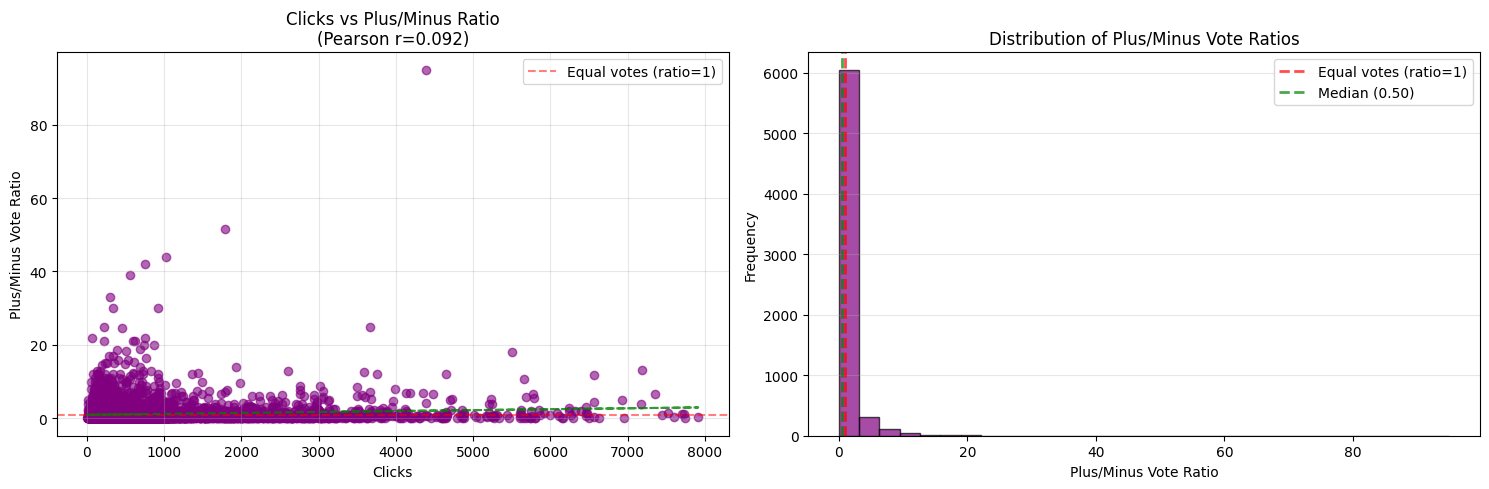

In [8]:
# Visualize plus/minus ratio distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

if plus_minus_ratios:
    # Scatter plot: Clicks vs Ratio
    ratio_clicks = [r["clicks"] for r in plus_minus_ratios]
    ratio_values = [r["ratio"] for r in plus_minus_ratios]
    
    ax1.scatter(ratio_clicks, ratio_values, alpha=0.6, color='purple')
    ax1.set_xlabel('Clicks')
    ax1.set_ylabel('Plus/Minus Vote Ratio')
    ax1.set_title(f'Clicks vs Plus/Minus Ratio\n(Pearson r={ratio_corr:.3f})')
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=1, color='red', linestyle='--', alpha=0.5, label='Equal votes (ratio=1)')
    ax1.legend()
    
    # Add trend line
    z = np.polyfit(ratio_clicks, ratio_values, 1)
    p = np.poly1d(z)
    ax1.plot(ratio_clicks, p(ratio_clicks), "g--", alpha=0.8, label='Trend line')
    
    # Histogram of ratios
    ax2.hist(ratio_values, bins=30, color='purple', alpha=0.7, edgecolor='black')
    ax2.axvline(x=1, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Equal votes (ratio=1)')
    ax2.axvline(x=np.median(ratio_values), color='green', linestyle='--', alpha=0.7, linewidth=2, label=f'Median ({np.median(ratio_values):.2f})')
    ax2.set_xlabel('Plus/Minus Vote Ratio')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Distribution of Plus/Minus Vote Ratios')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()